In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer 
from preprocessing import get_features_and_target

In [ ]:
cont_mean_std = torch.randn(16, 2)

model = TabTransformer(
    categories = (9,16, ),      # tuple containing the number of unique values within each category
    num_continuous = 16,                # number of continuous values
    dim = 32,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1,                   # feed forward dropout
    mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)

x_categ = (9, 12)     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_cont = (1, 16)               # assume continuous values are already normalized individually

pred = model(x_categ, x_cont) # (1, 1)
print(pred)

AttributeError: 'tuple' object has no attribute 'shape'

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tab_transformer_pytorch import TabTransformer
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Generate fake data
def generate_data(num_samples):
    x_categ = torch.randint(0, 10, (num_samples, 5))
    
    x_cont = torch.randn(num_samples, 15)
    
    y = torch.zeros(num_samples)
    for i in range(num_samples):
        if x_categ[i, 0] > 5 and x_cont[i, 0] > 0:
            y[i] = 2  
        elif x_categ[i, 1] < 3 or x_cont[i, 1] < -1:
            y[i] = 1 
        else:
            y[i] = 0  
    
    return x_categ, x_cont, y.long()

num_samples = 10000
x_categ, x_cont, y = generate_data(num_samples)

cont_mean = x_cont.mean(dim=0)
cont_std = x_cont.std(dim=0)
x_cont = (x_cont - cont_mean) / cont_std 
cont_mean_std = torch.stack([cont_mean, cont_std], dim=1)

# Model
model = TabTransformer(
    categories = (10, 10, 10, 10, 10), 
    num_continuous = 15,                
    dim = 64,                            
    dim_out = 3,                        
    depth = 6,                           
    heads = 8,                          
    attn_dropout = 0.1,                  
    ff_dropout = 0.1,                    
    mlp_hidden_mults = (4, 2),           
    mlp_act = nn.ReLU(),                 
    continuous_mean_std = cont_mean_std  
)

dataset = TensorDataset(x_categ, x_cont, y)
train_size = int(0.8 * len(dataset))  
test_size = len(dataset) - train_size 
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

num_epochs = 2

# Train
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0
    all_preds = []  
    all_labels = []  

    for batch_categ, batch_cont, batch_y in train_loader:
        
        optimizer.zero_grad()  
        
        outputs = model(batch_categ, batch_cont)
        loss = criterion(outputs, batch_y)  
        
        loss.backward() 
        optimizer.step()  
        
        total_loss += loss.item()  
        
        _, predicted = torch.max(outputs.data, 1) 
        all_preds.extend(predicted.numpy())  
        all_labels.extend(batch_y.numpy())  
    
    avg_loss = total_loss / len(train_loader)
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch [1/2], Loss: 0.6238, Accuracy: 0.7109
Epoch [2/2], Loss: 0.4544, Accuracy: 0.7875


In [ ]:
models = {
    "TabTransformer": TabTransformer(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
}

TypeError: TabTransformer.__init__() got an unexpected keyword argument 'random_state'

In [52]:
train_df = pd.read_csv("data/train_data.csv")
dev_df = pd.read_csv("data/development_data.csv")

x_train, y_train = get_features_and_target(train_df)
x_dev, y_dev = get_features_and_target(dev_df)

target_column = "PullTest (N)"  


In [58]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer



model = TabTransformer(
    categories = (),      # tuple containing the number of unique values within each category
    num_continuous = 8,                # number of continuous values
    dim = 32,                           # dimension, paper set at 32
    dim_out = 1,                        # binary prediction, but could be anything
    depth = 6,                          # depth, paper recommended 6
    heads = 8,                          # heads, paper recommends 8
    attn_dropout = 0.1,                 # post-attention dropout
    ff_dropout = 0.1,                   # feed forward dropout
    mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
)

x_categ = ()     # category values, from 0 - max number of categories, in the order as passed into the constructor above
x_cont = (2, 8)               # assume continuous values are already normalized individually

cont_mean = x_cont.mean(dim=0)
cont_std = x_cont.std(dim=0)
#x_cont = (x_cont - cont_mean) / cont_std 
#cont_mean_std = torch.stack([cont_mean, cont_std], dim=1)


pred = model(x_categ, x_cont) # (1, 1)
print(pred)

AssertionError: continuous_mean_std must have a shape of (8, 2) where the last dimension contains the mean and variance respectively

In [ ]:

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_dev)

mse = mean_squared_error(y_dev, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_dev, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

abs_errors = np.abs(predictions - y_dev)
sorted_errors = np.sort(abs_errors)
cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Absolute Error |y_pred - y_true|')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) of Absolute Errors')
plt.grid(True)
plt.show()

NameError: name 'predictions' is not defined

## Coefficient of Determination (R²)

The coefficient of determination, denoted as $( R^2 )$, is a commonly used metric to evaluate the performance of a regression model. It indicates how well the model explains the variance in the target variable \( y \).

### Definition

The formula for $( R^2 )$ is:

$$
R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}
$$

Where:

- $( SS_{\text{res}} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2)$: Residual Sum of Squares (model error)
-  $(SS_{\text{tot}} = \sum_{i=1}^{n} (y_i - \bar{y})^2)$: Total Sum of Squares (total variance in the data)

### Interpretation

- $( R^2 = 1)$: Perfect prediction – the model explains 100% of the variance in $( y)$
- $( R^2 = 0)$: The model does no better than simply predicting the mean of $( y )$
- $( R^2 < 0 )$: The model performs worse than a constant mean prediction

### Example

In this case, the model achieved an $( R^2 )$ score of **0.61**, which means it explains **61% of the total variance** in the target variable.

This is a moderate-to-good result, indicating that the model captures significant patterns in the data, but there is still room for improvement.

## Mean Squared Error (MSE)

The **Mean Squared Error (MSE)** is a standard regression metric that measures the average of the squared differences between the predicted values and the actual target values.

### Definition

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Where:

- $y_i$: true value  
- $\hat{y}_i$: predicted value  
- $n$: number of samples

### Interpretation

- MSE penalizes larger errors more strongly due to squaring.
- The result is in the **squared unit** of the target variable (e.g., mm², N², €²).
- A **lower MSE** indicates better prediction accuracy.
- Because of squaring, the MSE is sensitive to **outliers**.

### Example

In this case, the model yielded an MSE of **88,837**, which may seem large, but this must be interpreted in the context of the unit and range of the target variable.

## Root Mean Squared Error (RMSE)

The **Root Mean Squared Error (RMSE)** is the square root of the MSE and represents the average prediction error in the same unit as the target variable.

### Definition

$RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 } = \sqrt{MSE}$

### Interpretation

- RMSE is easier to interpret than MSE because it is in the **original unit** of the target variable.
- It gives a direct sense of **how far off predictions are**, on average.
- Like MSE, it is also sensitive to outliers due to the squaring.

### Example

In this case, the RMSE is approximately **298 N**.  
Given that the mean of the target variable (PullTest) is **2953 N**, this corresponds to a **relative prediction error of about 10.1 %**.

This means that, on average, the model's predictions deviate from the true pull test values by approximately 298 N.


In [12]:
results = {}

X_train_new = X_train.drop(columns=["Material", "Category", "Comments"])
X_dev_new = X_dev.drop(columns=["Material", "Category", "Comments"])

for name, model in models.items():
    model.fit(X_train_new, y_train)
    preds = model.predict(X_dev_new)
    
    mse = mean_squared_error(y_dev, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_dev, preds)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

NameError: name 'models' is not defined

In [29]:
results_df = pd.DataFrame(results).T
results_df = results_df.round(2)
print(results_df)

                     MSE    RMSE    R²
TabPFN          71549.75  267.49  0.69
Decision Tree   81260.90  285.06  0.64
Random Forest   73589.86  271.27  0.68
XGBoost        113405.48  336.76  0.50


In [ ]:
cdf_data = {}  

for name, model in models.items():
    model.fit(X_train_new, y_train)
    preds = model.predict(X_dev_new)
    
    mse = mean_squared_error(y_dev, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_dev, preds)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }
    
    abs_errors = np.abs(preds - y_dev)
    sorted_errors = np.sort(abs_errors)
    cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)
    cdf_data[name] = (sorted_errors, cdf)

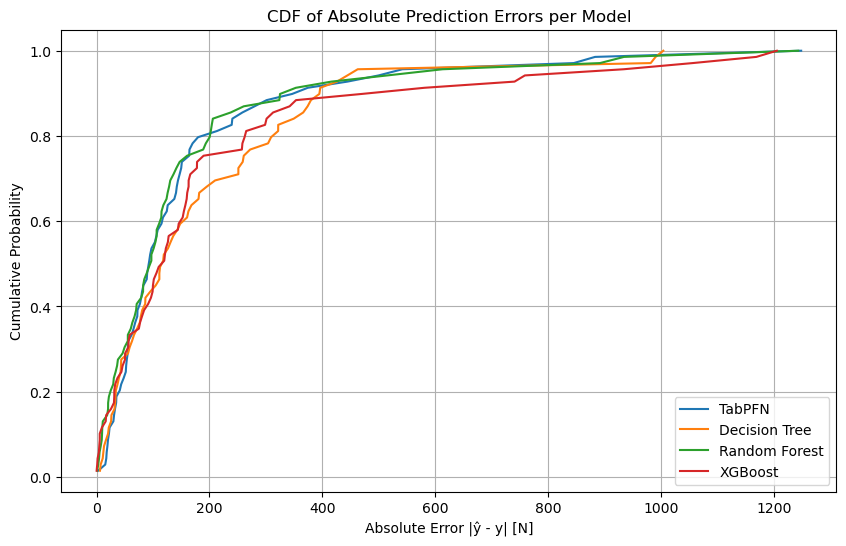

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, (errors, cdf) in cdf_data.items():
    plt.plot(errors, cdf, label=name)

plt.xlabel("Absolute Error |ŷ - y| [N]")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Absolute Prediction Errors per Model")
plt.grid(True)
plt.legend()
plt.show()